In [28]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import math

# GWAS summary statistic clustering
Data will be encoded into a standardized representation and then clustered to derive potential condition associations.

## Load & encode data

In [3]:
adhd_df = pd.read_csv('adhd_gwas_catalog_2022_cleaned.csv')
alzheimers_df = pd.read_csv('alzheimers_gwas_catalog_2022_cleaned.csv')
anxiety_disorder_df = pd.read_csv('anxiety_disorder_gwas_catalog_2022_cleaned.csv')
bipolar_disorder_df = pd.read_csv('bipolar_disorder_gwas_catalog_2022_cleaned.csv')
drug_dependence_df = pd.read_csv('drug_dependence_gwas_catalog_2022_cleaned.csv')
schizophrenia_df = pd.read_csv('schizophrenia_gwas_catalog_2022_cleaned.csv')
dfs = [
  adhd_df, 
  alzheimers_df, 
  anxiety_disorder_df, 
  bipolar_disorder_df, 
  drug_dependence_df, 
  schizophrenia_df,
]

### Naive encoding
Just use 1-hot encoding of gene implication (i.e. number all genes implicated in the given conditions from 0...N-1. Then create an N-dimensional vector for each condition where element i is 1 if the condition is associated with that gene, 0 if not).
The hypothesis is that similar conditions have implicated gene overlap.

In [6]:
all_genes = set()
for df in dfs:
  genes = df['gene'].unique()
  [all_genes.add(gene) for gene in genes]

print(f"Found {len(all_genes)} total genes.")

Found 1663 total genes.


In [16]:
all_genes_list = list(all_genes)
num_genes = len(all_genes_list)
gene_to_index = {all_genes_list[i]: i for i in range(num_genes)}

In [19]:
def encode_condition_df(df):
  vec = np.zeros(num_genes)
  condition_genes = df['gene'].unique()
  for gene in condition_genes:
    gene_index = gene_to_index[gene]
    vec[gene_index] = 1
  return vec


# Small test:
first_gene = all_genes_list[0]
df = pd.DataFrame([{'variant_and_allele': 'test', 'p_value': 0.01, 'trait': 'test', 'gene': first_gene}])
encoding = encode_condition_df(df)
assert encoding[0] == 1
assert sum(encoding) == 1

It works


In [35]:
# Encode them all!
encodings = pd.DataFrame({df['trait'].unique()[0]: encode_condition_df(df) for df in dfs})
encodings

,attention deficit hyperactivity disorder,late-onset Alzheimers disease,anxiety disorder,bipolar I disorder,alcohol and nicotine codependence,schizophrenia
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
1658,1.0,0.0,0.0,0.0,0.0,0.0
1659,0.0,0.0,0.0,0.0,0.0,1.0
1660,0.0,0.0,0.0,0.0,0.0,1.0
1661,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
# Actually needs to have vectors as rows not columns:
encodings = encodings.T
encodings

,0,1,2,3,4,5,6,7,8,9,...,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662
attention deficit hyperactivity disorder,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
late-onset Alzheimers disease,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anxiety disorder,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bipolar I disorder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alcohol and nicotine codependence,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
schizophrenia,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


## Cluster

In [39]:
# See docs here:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
model = AgglomerativeClustering(distance_threshold=0, 
                                n_clusters=None, 
                                linkage='ward')
clustering = model.fit(encodings)

In [26]:
# This code is from the scikit-learn examples!
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

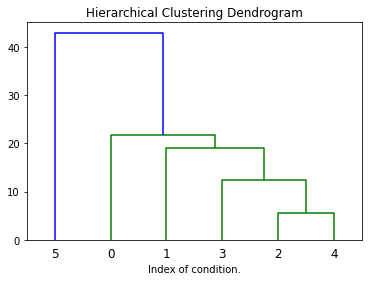

In [41]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Index of condition.")
plt.show()

### Observations
I need to review the algorithm and output to ensure I fully understand how to interpret this (as well as dig into the plotting code a bit more to include conditions on the x-axis for better interpretability). At this time though, to the best of my understanding, this chart indicates:


*   Conditions 2 and 4 are most closely related (anxiety disorder and alcohol and nicotine codependence).
*   Condition 5 is least similar to the others (schizophrenia)


This is a little surprising given that in my literature review I saw many mentions of Schizophrenia having overlap with other mental illnesses. I think the results are skewed at this time because there is more data for schizophrenia due to the way I implemented trait filtering - that will be revisited.

